Fine-tuning with Pre-trained AlexNet 
==========================================

This notebook shows you how to play with pre-trained AlexNet. First, let's update mxnet (CUDA version) to at least v1.6.0.

In [1]:
!pip install -q -U mxnet-cu101mkl==1.6.0.post0  # updating mxnet to at least v1.6
!pip install d2l

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


Now let's import the necessary libraries.

In [2]:
import os
from d2l import mxnet as d2l
import mxnet as mx
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss

### Loading and Transforming Dataset

To load the dataset properly, we need the massage the image data a bit by some `transfom` functions. First, we load the image data and resize it to the given size (224,224). Next, we convert the image NDArray of shape (H x W x C) in the range [0, 255] to a float32 tensor NDArray of shape (C x H x W) in the range (0, 1) using the `ToTensor` class. Last, we normalize an tensor of shape (C x H x W) with its mean and standard deviation by `Normalize`.

In [3]:
# import the datasets
import boto3
import os
from os import path
import pandas as pd
import zipfile

bucketname = 'mlu-courses-datalake' # replace with your bucket name
filename = 'MLA-CV/data/minc-2500.zip' # replace with your object key

pathname = '../../data/'
s3 = boto3.resource('s3')
if not path.exists("../../data/"):
    try:
        os.makedirs(pathname)
    except OSError:
        print ("Creation of the directory %s failed" % path)

s3.Bucket(bucketname).download_file(filename , '../../data/minc-2500.zip')

print ("Successfully created the directory %s " % path)
if not path.exists("../../data/minc-2500"):
    zipdata = zipfile.ZipFile('../../data/minc-2500.zip')
    zipdata.extractall('../../data/')
    !rm ../../data/minc-2500.zip

Successfully created the directory <module 'posixpath' from '/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/posixpath.py'> 


In [4]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

Now apply the predefined transform functions and load the train, validation and test sets.

In practice, reading data can be a significant performance bottleneck, especially when our model is simple or when our computer is fast. To make our life easier when reading from the datasets, we use a `DataLoader` of Gluon, which reads a minibatch of data with size `batch_size` each time.

In [5]:
batch_size = 16

path = '../../data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

train_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True)

validation_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False)

test_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False)

### Fine-tuning Pretrained AlexNet

To fine-tune a pretrained model, we need the following 4 steps:
1. Define a neural network **finetune_net** with AlexNet architecture, with given number of output classes. Note that for `gluon.model_zoo.vision.alexnet` the default parameter `pretrained` is False, which means it will only return us an AlexNet architecture rather than an AlexNet architecture with pretrained weights.

1. Initialize the **finetune_net** with [Xavier initialization](http://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#xavier-initialization) to make sure our random initialized weights are neither too small nor too huge.

1. Define another neural network, **pretrained_net**, and load the pretrained AlexNet model (which was trained on ImageNet) on it. Here, by specifying ``pretrained=True``, it will automatically download the model from the model zoo if necessary. For more pretrained models, please refer to [GluonCV Model Zoo](https://gluon-cv.mxnet.io/model_zoo/index.html).

1. Apply the trained weights (except last layer) from **pretrained_net** to **finetune_net**, and output **finetune_net**.

In [6]:
def FineTuneAlexnet(classes, ctx):
    '''
    classes: number of the output classes 
    ctx: training context (CPU or GPU)
    '''
    finetune_net = gluon.model_zoo.vision.alexnet(classes=classes, pretrained=False, ctx=ctx)
    finetune_net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
    pretrained_net = gluon.model_zoo.vision.alexnet(pretrained=True, ctx=ctx)
    finetune_net.features = pretrained_net.features
    
    return finetune_net

Next, we set up the hyperparameters, such training context `ctx` (GPU or CPU), the number of epochs to train, the learning rate of optimization algorithms.

In [7]:
ctx = mx.gpu() # Set this to CPU or GPU depending on your training instance
epochs = 10
learning_rate = 0.001
num_outputs = 6  # 6 output classes
net = FineTuneAlexnet(num_outputs, ctx)
net

AlexNet(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), Activation(relu))
    (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (2): Conv2D(64 -> 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), Activation(relu))
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (4): Conv2D(192 -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (5): Conv2D(384 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (6): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (7): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (8): Flatten
    (9): Dense(9216 -> 4096, Activation(relu))
    (10): Dropout(p = 0.5, axes

Besides, we need to specify the loss function. Since this problem is a multiclass classification task, we will use softmax as our loss funciton.

In [8]:
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})

Our network is almost ready to be finetuned! One last thing before the finetuning is to define the `accuracy` function for evulating our model.

In [9]:
def finetune_accuracy(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) == label.astype('float32')).mean()

Now it's the training time! Starting with the outer loop, we will have 10 epochs (10 full pass through our dataset). Within the inner loop, we yield each mini-batch from the `train_loader`, and update the weights based on the average statistics of this mini-batch.

In [10]:
# Starting the outer loop, we will have 10 epochs (10 full pass through our dataset)
for epoch in range(epochs):
    
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_etropy_loss(output, label)
        loss.backward()
        train_acc += finetune_accuracy(output, label)
        train_loss += loss.mean()
        trainer.step(data.shape[0])
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        valid_acc += finetune_accuracy(output, label)
        val_loss += softmax_cross_etropy_loss(output, label).mean()
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch, train_loss.asnumpy()[0], train_acc.asnumpy()[0], val_loss.asnumpy()[0], valid_acc.asnumpy()[0]))

Epoch 0: train loss 1.459, train acc 0.472, val loss 0.785, val acc 0.745
Epoch 1: train loss 0.849, train acc 0.692, val loss 0.576, val acc 0.854
Epoch 2: train loss 0.670, train acc 0.763, val loss 0.500, val acc 0.865
Epoch 3: train loss 0.575, train acc 0.792, val loss 0.488, val acc 0.854
Epoch 4: train loss 0.497, train acc 0.826, val loss 0.440, val acc 0.865
Epoch 5: train loss 0.422, train acc 0.852, val loss 0.418, val acc 0.896
Epoch 6: train loss 0.377, train acc 0.862, val loss 0.424, val acc 0.880
Epoch 7: train loss 0.335, train acc 0.882, val loss 0.427, val acc 0.880
Epoch 8: train loss 0.342, train acc 0.875, val loss 0.391, val acc 0.885
Epoch 9: train loss 0.305, train acc 0.902, val loss 0.393, val acc 0.891


### Test predictions

Let's validate our model predictions. At the same predict the results of given random sample images, we use the `show_images` function and see the what does the random sample images look like.

In [11]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


[2. 3. 0. 3. 3. 4. 5. 4. 0. 2. 3. 4. 5. 0. 1. 1.]
<NDArray 16 @gpu(0)>


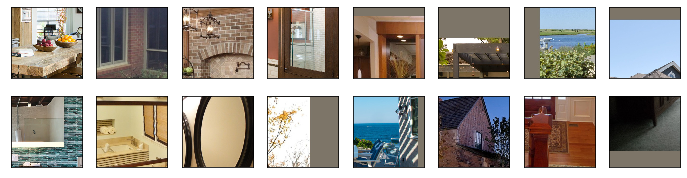

In [12]:
random_test_sample = gluon.data.DataLoader(gluon.data.vision.ImageFolderDataset(test_path),
                                    batch_size=2*8, shuffle=True)

for data, label in random_test_sample:
    show_images(data, 2, 8);
    data = data.as_in_context(ctx)
    pred = net(transform_test(data))
    print(pred.argmax(axis=1))
    break